In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pickle
%matplotlib inline

In [3]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00


In [4]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [5]:
FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/Arxiv Topic Classification/first 1 million/"

In [6]:
train_data = pd.read_csv(FILE_PATH + "train_data.csv")
test_data = pd.read_csv(FILE_PATH + "test_data.csv")

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949875 entries, 0 to 949874
Columns: 157 entries, text to stat.TH
dtypes: int64(156), object(1)
memory usage: 1.1+ GB


In [8]:
train_data.head()

,text,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,cond-mat.mes-hall,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,calcul prompt diphoton product cross section t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sparsitycertifi graph decomposit describ new a...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,evolut earthmoon system base dark matter field...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,determin stirl cycl number count unlabel acycl...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dyadic lambdaalpha lambdaalpha paper show comp...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# remove the "text" from the label_name
label_name = list(train_data.columns)
label_name.pop(0)
print(label_name)

['astro-ph', 'astro-ph.CO', 'astro-ph.EP', 'astro-ph.GA', 'astro-ph.HE', 'astro-ph.IM', 'astro-ph.SR', 'cond-mat.dis-nn', 'cond-mat.mes-hall', 'cond-mat.mtrl-sci', 'cond-mat.other', 'cond-mat.quant-gas', 'cond-mat.soft', 'cond-mat.stat-mech', 'cond-mat.str-el', 'cond-mat.supr-con', 'cs.AI', 'cs.AR', 'cs.CC', 'cs.CE', 'cs.CG', 'cs.CL', 'cs.CR', 'cs.CV', 'cs.CY', 'cs.DB', 'cs.DC', 'cs.DL', 'cs.DM', 'cs.DS', 'cs.ET', 'cs.FL', 'cs.GL', 'cs.GR', 'cs.GT', 'cs.HC', 'cs.IR', 'cs.IT', 'cs.LG', 'cs.LO', 'cs.MA', 'cs.MM', 'cs.MS', 'cs.NA', 'cs.NE', 'cs.NI', 'cs.OH', 'cs.OS', 'cs.PF', 'cs.PL', 'cs.RO', 'cs.SC', 'cs.SD', 'cs.SE', 'cs.SI', 'cs.SY', 'econ.EM', 'econ.GN', 'econ.TH', 'eess.AS', 'eess.IV', 'eess.SP', 'eess.SY', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math-ph', 'math.AC', 'math.AG', 'math.AP', 'math.AT', 'math.CA', 'math.CO', 'math.CT', 'math.CV', 'math.DG', 'math.DS', 'math.FA', 'math.GM', 'math.GN', 'math.GR', 'math.GT', 'math.HO', 'math.IT', 'math.KT', 'math.LO', 'math.MG',

In [10]:
X_train, y_train = train_data["text"], train_data[label_name]

In [11]:
X_test, y_test = test_data["text"], test_data[label_name]

## Data Statisctics for UNIQUE_WORD_COUNT and MAX_PAD_LENGTH

In [12]:
# unique_word_dict can be used to choose the optimal number of vocabs
# length list can be used to choose the padding length for the tokenization process
def findUniqueWord(text_series : pd.core.series.Series):
  """
  Function to find the count of the unique words and length of the articles

  Arguments:
    text_series : series of text data

  Output:
    unique_word_dict : dictionary with unique word and its count in the text data
    length : list of length of each article
  """
  unique_word_dict = {}
  length = []
  for sentence in tqdm(text_series):
    words = sentence.split()
    length.append(len(words))
    for word in words:
      unique_word_dict[word] = unique_word_dict.get(word, 0) + 1

  return length, unique_word_dict

In [15]:
length, unique_word_dict = findUniqueWord(train_data["text"])

  0%|          | 0/949875 [00:00<?, ?it/s]

<ipython-input-16-5e838970321f>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(length, bins = 30, hist = True, kde = True)


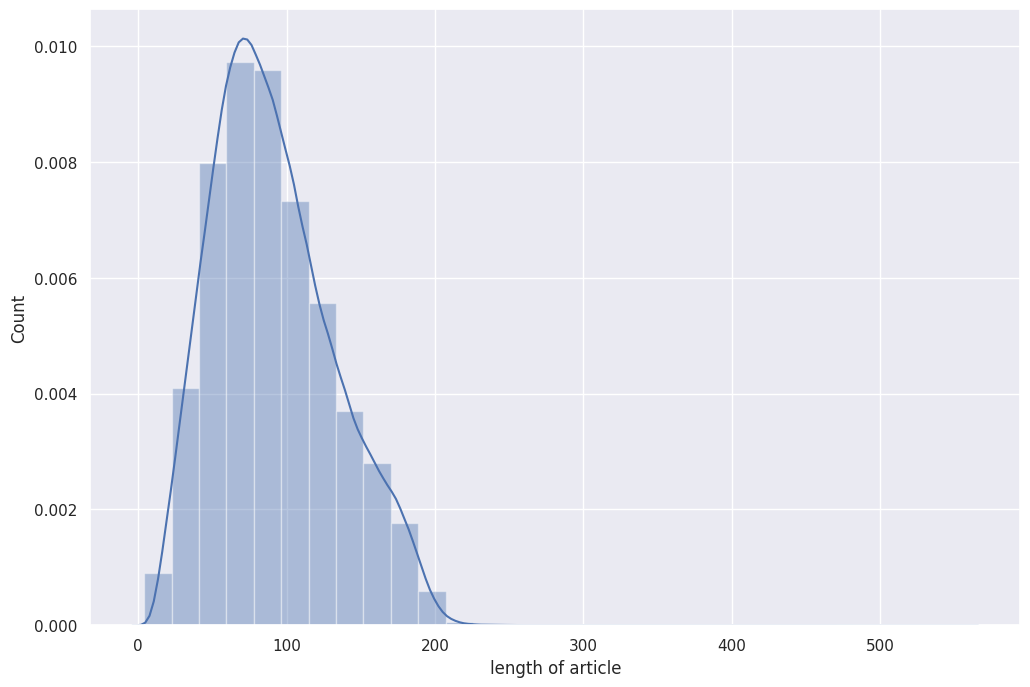

In [16]:
sns.set(rc={'figure.figsize':(12, 8)})
ax = sns.distplot(length, bins = 30, hist = True, kde = True)
ax.set(xlabel = "length of article", ylabel = "Count")
plt.show()

In [17]:
pd.Series(length).describe()

count    949875.000000
mean         91.192550
std          40.799334
min           4.000000
25%          61.000000
50%          86.000000
75%         117.000000
max         558.000000
dtype: float64

<ipython-input-20-00f132c2ac28>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(word_count_list, bins = 30, hist = True, kde = True)


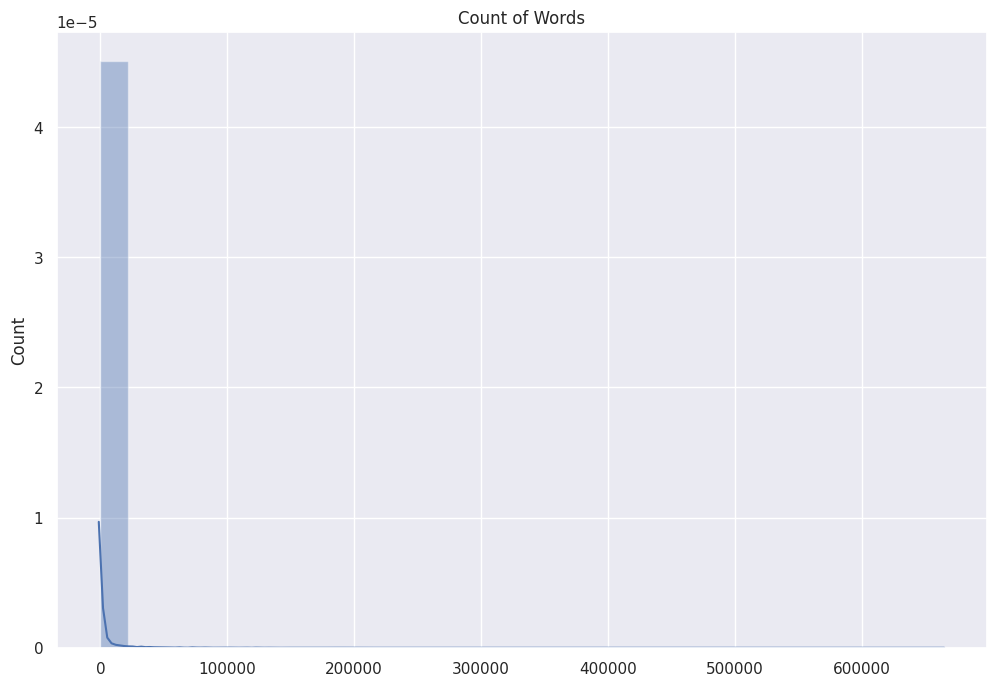

In [20]:
word_count_list = list(unique_word_dict.values())
ax = sns.distplot(word_count_list, bins = 30, hist = True, kde = True)
ax.set(ylabel = "Count", title = "Count of Words")
plt.show()

In [19]:
print(f"Total number of words in the text : {len(word_count_list)}")

Total number of words in the text : 295365


In [22]:
threshold_word_count = 50
len([i for i in word_count_list if i > threshold_word_count])

22344

In [24]:
UNIQUE_WORD_COUNT = 25_000
MAX_PAD_LENGTH = 210

## Tokenization

In [12]:
UNIQUE_WORD_COUNT = 25_000
MAX_PAD_LENGTH = 210

In [13]:
tokenizer = Tokenizer(num_words = UNIQUE_WORD_COUNT)
# tokenizer.fit_on_texts(X_train)

In [14]:
# saving the tokenizer
# with open(FILE_PATH + 'tokenizer.pkl', 'wb') as handle:
#   pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
with open(FILE_PATH + 'tokenizer.pkl', 'rb') as handle:
  tokenizer = pickle.load(handle)

In [16]:
%%time
train_sequences = tokenizer.texts_to_sequences(X_train)
print(train_sequences)
train_padded = pad_sequences(train_sequences, maxlen = MAX_PAD_LENGTH, padding = 'post', truncating = 'post')
print(train_padded[0])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[  103  2535  4041   167   327   529  2609   757    20   726   338   103
   289    23  4456    22   167   438   260   246   729  1061  8047    30
   289   306 12130 23857  8842   127    63 22577  3422  1188   502   604
 16157  1187   554   140    48    28  1590   103  1066   531   587   147
    17  3664  2609   123   748   394   189  3272    17   123   223    41
  4041   246   324    20    51   729  1061   757    41  4041   246   227
   542   464   707   324   705    60   757     6   399   457   258    53
  6902   317   373     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [17]:
%%time
test_sequences = tokenizer.texts_to_sequences(X_test)
print(test_sequences[0])
test_padded = pad_sequences(test_sequences, maxlen = MAX_PAD_LENGTH, padding = "post", truncating = "post")
print(test_padded[0])

[577, 4225, 384, 59, 882, 384, 295, 124, 577, 4225, 384, 59, 7345, 544, 110, 384, 324, 563, 582, 882, 72, 18, 7345, 384, 499, 1266, 1447, 187, 230, 3347, 495, 1107, 1238, 271, 1246, 156, 413, 908, 980, 329, 10, 124, 110, 7345, 18, 19882, 964, 2670, 497, 597, 374, 18, 21315, 238, 168, 2334, 822, 125, 1266, 1447, 454, 8, 62, 92, 318, 1131, 1070, 181, 18, 250, 124, 110, 534, 11697, 1101, 49, 21315, 238, 455, 1980, 182, 168, 881, 271, 1246, 555, 7685, 7345, 617, 166, 19244, 7345]
[  577  4225   384    59   882   384   295   124   577  4225   384    59
  7345   544   110   384   324   563   582   882    72    18  7345   384
   499  1266  1447   187   230  3347   495  1107  1238   271  1246   156
   413   908   980   329    10   124   110  7345    18 19882   964  2670
   497   597   374    18 21315   238   168  2334   822   125  1266  1447
   454     8    62    92   318  1131  1070   181    18   250   124   110
   534 11697  1101    49 21315   238   455  1980   182   168   881   271
  1246  

## Model Development

In [18]:
y_train.head()

,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,cond-mat.mes-hall,cond-mat.mtrl-sci,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
N_CLASSES = 156

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [21]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [22]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [23]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
OUTPUT_DIM = N_CLASSES

## Mode Development
inputs = layers.Input(shape=(MAX_PAD_LENGTH,))
embedding_layer = TokenAndPositionEmbedding(MAX_PAD_LENGTH, UNIQUE_WORD_COUNT, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(OUTPUT_DIM, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [24]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 31.0 MB/s eta 0:00:00


In [25]:
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [tf.keras.metrics.BinaryAccuracy(),
           tfa.metrics.HammingLoss(mode='multilabel'),
           ]
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 210)]             0         
                                                                 
 token_and_position_embeddin  (None, 210, 32)          806720    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 210, 32)          10656     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [ ]:
history = model.fit(train_padded, y_train, batch_size=512, epochs = 5, validation_data=(test_padded, y_test))

In [29]:
model_path = FILE_PATH + "model2.h5"
model.save(model_path)

In [30]:
history_path = FILE_PATH + "history2.history"
with open(history_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)